In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import classification_report, auc, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import cm

plt.style.use('../figures/journal-style.mplstyle')
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
    return z

def remove_spines(axes):
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)
def hide_axes(axes):
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

In [52]:
triageData = pd.read_excel("../data/triageOutput/validationOutput.xlsx")

triageData.sort_values(by=['Triage class'],inplace=True,ascending=True)        
#triageDataNoConf = triageData.loc[(triageData['DL-QC-L']==0)]
#triageDataHighConfDiag = triageData.loc[(triageData['DL-QC-H']==1)]

In [53]:
triageData['Triage class'].value_counts(sort=False)

0     32
1     59
2     54
3     23
4     45
5    109
6     17
7    186
Name: Triage class, dtype: int64

In [54]:
# Summarise triage class occurence BEST2
print(len(triageData))
triageData['Triage class'].value_counts(sort=False)/len(triageData)

525


0    0.060952
1    0.112381
2    0.102857
3    0.043810
4    0.085714
5    0.207619
6    0.032381
7    0.354286
Name: Triage class, dtype: float64

0.8174904942965779 0.9274809160305344


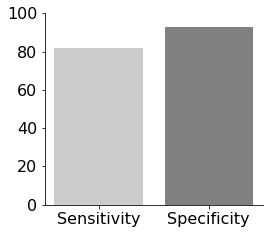

In [55]:
# Gradually replace everything with AI data and check sens/spec
triageDataCopy = triageData.copy(deep=True)
#triageDataCopy = triageDataCopy[(triageDataCopy['Triage class']!=0)]


tn, fp, fn, tp = confusion_matrix(triageDataCopy['Endoscopy (at least C1 or M3) + Biopsy (IM)'], triageDataCopy['Cytosponge']).ravel()
pathologistSpecificityCS = tn / (tn+fp)
pathologistSensitivityCS = tp / (tp+fn)

print(pathologistSensitivityCS,pathologistSpecificityCS)

#triageDataCopy.loc[triageData['Triage class']==0, "Cytosponge"] = 0 

#tn, fp, fn, tp = confusion_matrix(triageDataCopy['Endoscopy (at least C1M3)'], triageDataCopy['Cytosponge']).ravel()
#pathologistSpecificity = tn / (tn+fp)
#pathologistSensitivity = tp / (tp+fn)

#print(pathologistSensitivity,pathologistSpecificity)

plt.figure(figsize=(4,3.5))

objects = ('Sensitivity', 'Specificity')
y_pos = np.arange(len(objects))
performance = [pathologistSensitivityCS*100,pathologistSpecificityCS*100]

plt.bar(y_pos, performance, align='center', alpha=1, color=[[.8,.8,.8],[.5,.5,.5]])

plt.xticks(y_pos, objects)
#plt.ylabel('[%]')
#plt.xlabel('Pathologist only',fontweight='bold')
plt.ylim(0,100)
#plt.title('Programming language usage')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#for i, v in enumerate(performance):
#    plt.text(y_pos[i]-0.2, v + 5, str(round(v,1))+'%')
plt.savefig('../figures/triageGraphics/pathologistOnlySensSpec.pdf')

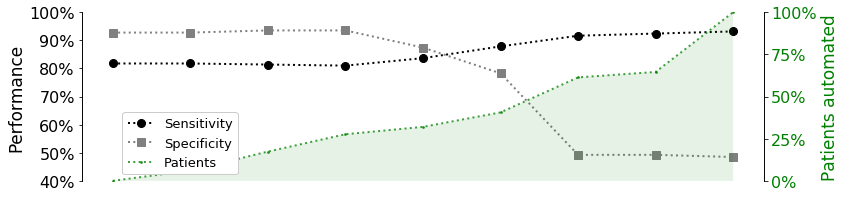

In [56]:
groups=('Path','0','0-1','0-2','0-3','0-4','0-5','0-6','0-7')
groupType = [0,0,0,1,1,1,1,1]
fig, ax1 = plt.subplots(figsize=(12,3))
ax2 = ax1.twinx()
incrementalSensitivities = [pathologistSensitivityCS*100]
incrementalSpecificities = [pathologistSpecificityCS*100]
patientCountAutomatedBO = [0]
for i in range(0,8):
    triageDataLowToHigh = triageData.copy(deep=True)
    #triageDataLowToHigh = triageDataLowToHigh[(triageDataLowToHigh['Triage class']!=0)]
    for k in range(0,i+1):
        #print(k)
        triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']==k, "Cytosponge"] = groupType[k]     
    patientCountAutomatedBO.append(len(triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']<=i]))
    tn, fp, fn, tp = confusion_matrix(triageDataLowToHigh['Endoscopy (at least C1 or M3) + Biopsy (IM)'], triageDataLowToHigh['Cytosponge']).ravel()
    pathologistSpecificity = tn / (tn+fp)
    pathologistSensitivity = tp / (tp+fn)
    #print(i,pathologistSensitivity,pathologistSpecificity,patientCountAutomated)
    incrementalSensitivities.append(pathologistSensitivity*100)
    incrementalSpecificities.append(pathologistSpecificity*100)
    #print(triageDataLowToHigh['Cytosponge'].value_counts())
    
ax1.set_ylim(40,100)
ax2.set_ylim(0,len(triageData))
ax2.fill_between(groups, 0, patientCountAutomatedBO, facecolor="g", alpha=0.1)
ax1.plot(groups,incrementalSensitivities,linestyle=':',marker='o',color='black',markersize=8,label='Sensitivity')
ax1.plot(groups,incrementalSpecificities,linestyle=':',marker='s',color='grey',markersize=8,label='Specificity')
ax2.plot(groups,patientCountAutomatedBO,linestyle=':',marker='p',color='g',markersize=2,label='Patients',alpha=0.75)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Performance')
ax2.set_ylabel('Patients automated', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.set_yticks([40,50,60,70,80,90,100])
ax1.set_yticklabels(['40%','50%','60%','70%','80%','90%','100%'])
ax2.set_yticks([0,len(triageData)*0.25,len(triageData)/2,len(triageData)*0.75,len(triageData)])
ax2.set_yticklabels(['0%','25%','50%','75%','100%'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower left',facecolor='white',framealpha=1,bbox_to_anchor=(0.05, 0., 0.5, 0.5))
ax1.get_xaxis().set_visible(False)
#plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/triageGraphics/sensSpecCount-1-to-1-6.pdf')

In [57]:
incrementalSensitivities

[81.74904942965779,
 81.74904942965779,
 81.36882129277566,
 80.98859315589354,
 83.65019011406845,
 87.83269961977186,
 91.63498098859316,
 92.39543726235742,
 93.15589353612167]

In [58]:
incrementalSpecificities

[92.74809160305344,
 92.74809160305344,
 93.51145038167938,
 93.51145038167938,
 87.40458015267176,
 78.2442748091603,
 49.23664122137404,
 49.23664122137404,
 48.473282442748086]

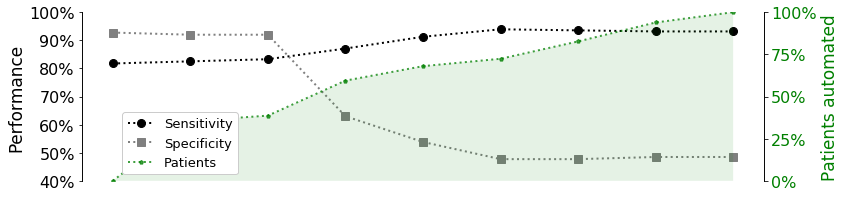

In [59]:
groups=('Path','0','0-1','0-2','0-3','0-4','0-5','0-6','0-7')
groupType = [0,0,0,1,1,1,1,1]
fig, ax1 = plt.subplots(figsize=(12,3))
ax2 = ax1.twinx()
incrementalSensitivities = [pathologistSensitivityCS*100]
incrementalSpecificities = [pathologistSpecificityCS*100]
patientCountAutomatedTD = []
for i in range(0,8):
    triageDataLowToHigh = triageData.copy(deep=True)
    #triageDataLowToHigh = triageDataLowToHigh[(triageDataLowToHigh['Triage class']!=0)]
    for k in range(0,i+1):
        #print(7-k-1)
        triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']==8-k-1, "Cytosponge"] = groupType[8-k-1]
    patientCountAutomatedTD.append(len(triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']>=k]))
    tn, fp, fn, tp = confusion_matrix(triageDataLowToHigh['Endoscopy (at least C1 or M3) + Biopsy (IM)'], triageDataLowToHigh['Cytosponge']).ravel()
    pathologistSpecificity = tn / (tn+fp)
    pathologistSensitivity = tp / (tp+fn)
    #print(i,pathologistSensitivity,pathologistSpecificity)
    incrementalSensitivities.append(pathologistSensitivity*100)
    incrementalSpecificities.append(pathologistSpecificity*100)

#incrementalSensitivities.reverse()
#incrementalSpecificities.reverse()
patientCountAutomatedTD.append(0)
patientCountAutomatedTD.reverse()
    
ax1.set_ylim(40,100)
ax2.set_ylim(0,len(triageData))
ax2.fill_between(groups, 0, patientCountAutomatedTD, facecolor="g", alpha=0.1)
ax1.plot(groups,incrementalSensitivities,linestyle=':',marker='o',color='black',markersize=8,label='Sensitivity')
ax1.plot(groups,incrementalSpecificities,linestyle=':',marker='s',color='grey',markersize=8,label='Specificity')
ax2.plot(groups,patientCountAutomatedTD,linestyle=':',marker='p',color='g',markersize=4,label='Patients',alpha=0.75)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Performance')
ax2.set_ylabel('Patients automated', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.set_yticks([40,50,60,70,80,90,100])
ax1.set_yticklabels(['40%','50%','60%','70%','80%','90%','100%'])
ax2.set_yticks([0,len(triageData)*0.25,len(triageData)/2,len(triageData)*0.75,len(triageData)])
ax2.set_yticklabels(['0%','25%','50%','75%','100%'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower left',facecolor='white',framealpha=1,bbox_to_anchor=(0.05, 0., 0.5, 0.5))
ax1.get_xaxis().set_visible(False)
plt.savefig('../figures/triageGraphics/sensSpecCount-1-6-to-6.pdf')

In [60]:
incrementalSensitivities

[81.74904942965779,
 82.50950570342205,
 83.26996197718631,
 87.07224334600761,
 91.25475285171103,
 93.91634980988593,
 93.5361216730038,
 93.15589353612167,
 93.15589353612167]

In [61]:
incrementalSpecificities

[92.74809160305344,
 91.98473282442748,
 91.98473282442748,
 62.97709923664122,
 53.81679389312977,
 47.70992366412214,
 47.70992366412214,
 48.473282442748086,
 48.473282442748086]

In [62]:
groupTypeReplace = [1,1,1,0,0,0,1,1]
groupType = [0,0,0,1,1,1,1,1]
patientCountAutomated = 0
triageDataEndModel = triageData.copy(deep=True)
for i in range(0,8):
    #print(i)
    if groupTypeReplace[i] is 1:
        print(i,groupType[i])
        triageDataEndModel.loc[triageDataEndModel['Triage class']==i, "Cytosponge"] = groupType[i]
        patientCountAutomated += len(triageDataEndModel.loc[triageDataEndModel['Triage class']==i])
tn, fp, fn, tp = confusion_matrix(triageDataEndModel['Endoscopy (at least C1 or M3) + Biopsy (IM)'], triageDataEndModel['Cytosponge']).ravel()
print(triageDataEndModel['Cytosponge'].value_counts())
pathologistSpecificity = tn / (tn+fp)
pathologistSensitivity = tp / (tp+fn)
#print(i,pathologistSensitivity,pathologistSpecificity)
print(pathologistSensitivity*100)
print(pathologistSpecificity*100)
print(patientCountAutomated,len(triageData),str(round(patientCountAutomated/len(triageData)*100,2)) + '%')



0 0
1 0
2 0
6 1
7 1
0    289
1    236
Name: Cytosponge, dtype: int64
82.50950570342205
92.74809160305344
348 525 66.29%


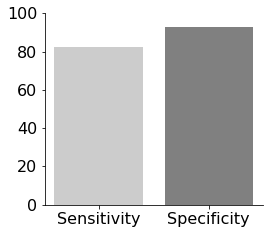

In [49]:
pathologistSensitivityCS = 0.825
pathologistSpecificityCS = 0.927

#triageDataCopy.loc[triageData['Triage class']==0, "Cytosponge"] = 0 

#tn, fp, fn, tp = confusion_matrix(triageDataCopy['Endoscopy (at least C1M3)'], triageDataCopy['Cytosponge']).ravel()
#pathologistSpecificity = tn / (tn+fp)
#pathologistSensitivity = tp / (tp+fn)

#print(pathologistSensitivity,pathologistSpecificity)

plt.figure(figsize=(4,3.5))

objects = ('Sensitivity', 'Specificity')
y_pos = np.arange(len(objects))
performance = [pathologistSensitivityCS*100,pathologistSpecificityCS*100]

plt.bar(y_pos, performance, align='center', alpha=1, color=[[.8,.8,.8],[.5,.5,.5]])

plt.xticks(y_pos, objects)
#plt.ylabel('[%]')
#plt.xlabel('Pathologist only',fontweight='bold')
plt.ylim(0,100)
#plt.title('Programming language usage')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#for i, v in enumerate(performance):
#    plt.text(y_pos[i]-0.2, v + 5, str(round(v,1))+'%')
plt.savefig('../figures/triageGraphics/pathologistTriageSensSpec.pdf')

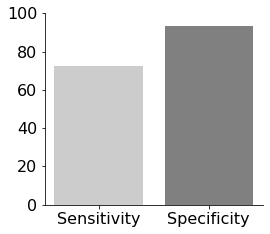

In [50]:
pathologistSensitivityCS = 0.726
pathologistSpecificityCS = 0.931

#triageDataCopy.loc[triageData['Triage class']==0, "Cytosponge"] = 0 

#tn, fp, fn, tp = confusion_matrix(triageDataCopy['Endoscopy (at least C1M3)'], triageDataCopy['Cytosponge']).ravel()
#pathologistSpecificity = tn / (tn+fp)
#pathologistSensitivity = tp / (tp+fn)

#print(pathologistSensitivity,pathologistSpecificity)

plt.figure(figsize=(4,3.5))

objects = ('Sensitivity', 'Specificity')
y_pos = np.arange(len(objects))
performance = [pathologistSensitivityCS*100,pathologistSpecificityCS*100]

plt.bar(y_pos, performance, align='center', alpha=1, color=[[.8,.8,.8],[.5,.5,.5]])

plt.xticks(y_pos, objects)
#plt.ylabel('[%]')
#plt.xlabel('Pathologist only',fontweight='bold')
plt.ylim(0,100)
#plt.title('Programming language usage')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#for i, v in enumerate(performance):
#    plt.text(y_pos[i]-0.2, v + 5, str(round(v,1))+'%')
plt.savefig('../figures/triageGraphics/pathologistFullyAutSensSpec.pdf')